# Opinion detector

**Participants:**
- Roger Baiges Trilla
- Adrià Cantarero Carreras

**Subject:**
- Processament del Llenguatge Humà

**Course:** 2024

**Degree:** Intel·ligència Artificial


## IMPORTS

In [44]:
from nltk.corpus import movie_reviews as mr
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import string

Necessary functions in order to avoid warnings on MacOS

In [45]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, message="overflow encountered in cast")

In [46]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

Downloading the necessary dataset and tools

In [47]:
# Ensure we have the necessary datasets and tools from NLTK
nltk.download('movie_reviews')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/rogerbaigess/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rogerbaigess/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rogerbaigess/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## PREPROCESSING THE DATASET

In [48]:
# Create a list with all the reviews and their respective categories

documents = [(list(mr.words(fileid)), category)
             for category in mr.categories()
             for fileid in mr.fileids(category)]
data = [' '.join(words) for words, _ in documents]
labels = [category for _, category in documents]

# Divide the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)

# SUPERVISED MODELS

In [49]:
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Define the stopwords list
stop_words = set(stopwords.words('english'))

# Extending the stopwords list with movie-related words
movie_related_stopwords = [
    'movie', 'film', 'cinema', 'actor', 'actress', 'director', 'scene', 'screen', 'dvd', 'blu-ray', 
    'hollywood', 'plot', 'story', 'character', 'characters', 'storyline', 'cinematography', 'production', 
    'performances', 'cast', 'role', 'roles', 'dialogue', 'narrative', 'franchise', 'sequel', 'prequel', 
    'soundtrack', 'score', 'genre', 'genres', 'trailer', 'trailers', 'review', 'reviews', 'viewer', 
    'viewers', 'audience', 'critic', 'critics', 'acting', 'screenplay', 'visual', 'effects', 'cgi', 
    'theme', 'themes', 'setting', 'shot', 'shots', 'angle', 'angles', 'lighting', 'edit', 'edits', 
    'editing', 'version', 'versions', 'adaptation', 'series', 'sequels', 'prequels', 'installment', 
    'installments', 'chapter', 'chapters', 'release', 'releases', 'premiere', 'cameo', 'cameos', 'star', 
    'stars', 'starring', 'feature', 'featured', 'leads', 'supporting', 'extra', 'extras', 'portray', 
    'portrays', 'portrayed', 'portrayal', 'nominated', 'nomination', 'award', 'awards', 'win', 'wins', 
    'winner', 'losers', 'gross', 'box', 'office', 'ticket', 'budget', 'profit', 'profits', 'break', 
    'record', 'filmmaker', 'make', 'makes', 'made', 'creator', 'craft', 'shoot', 'shot', 'direct', 
    'produce', 'write', 'writes', 'edit', 'visuals', 'imagery', 'picture', 'photography', 'art', 
    'design', 'sound', 'music', 'melody', 'tune', 'background', 'style', 'classify', 'classified', 
    'classification', 'segment', 'section', 'part', 'feature', 'element', 'aspect', 'detail'
]

stop_words.update(movie_related_stopwords)

def preprocessed_data(document):
    """
    Preprocesses a given document by removing numbers, punctuation, converting to lowercase,
    tokenizing, removing stopwords, and lemmatizing the tokens.

    Parameters:
    - document (str): The document to be preprocessed.

    Returns:
    - str: The preprocessed document as a single string.
    """
    # Remove numbers
    document = re.sub(r'\d+', '', document)
    
    # Remove punctuation and convert to lowercase
    document = document.translate(str.maketrans('', '', string.punctuation)).lower()
    
    # Tokenize the document
    tokens = word_tokenize(document)
    
    # Initialize the lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # Remove stopwords and lemmatize the tokens
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    # Combine the filtered tokens back into a single string
    return ' '.join(filtered_tokens)

# Apply the improved_preprocess function to the training and testing data
data_train_processed = [preprocessed_data(doc) for doc in X_train]
data_test_processed = [preprocessed_data(doc) for doc in X_test]


In [50]:
# Use CountVectorizer to convert data to a matrix of token counts
vectorizer = CountVectorizer(min_df=5)
data_train_processed = vectorizer.fit_transform(data_train_processed)
data_test_processed = vectorizer.transform(data_test_processed)

### INITIALIZE THE CLASSIFIERS

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB


# Initialize the classifiers    
rf_clf = RandomForestClassifier(random_state=42)
knn_clf = KNeighborsClassifier()
svm_clf = SVC(random_state=42)
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
lr_clf = LogisticRegression(random_state=42)
nb_clf = MultinomialNB()

### SEARCH THE BEST HYPERPARAMETERS WITH CROSS-VALIDATION

In [52]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grids

rf_param_grid = {
    'n_estimators': [100, 300, 750, 1500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
}

knn_param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}

svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto'],
    'degree': [3, 5],
}

xgb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7]
}


lr_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['liblinear', 'lbfgs', 'newton-cg'],
    'max_iter': [200, 300, 400],
}

nb_param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 50.0],
    'fit_prior': [True, False],
}



# Map model names to their corresponding grid
param_grid_dict = {
    "Random Forest": rf_param_grid,
    "K-Nearest Neighbors": knn_param_grid,
    "SVM": svm_param_grid,
    "XGBoost": xgb_param_grid,
    "Logistic Regression": lr_param_grid,
    "Naive Bayes": nb_param_grid
}

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder 


classifiers = {
    "Random Forest": (rf_clf, False),
    "K-Nearest Neighbors": (knn_clf, False),
    "SVM": (svm_clf, False),
    "XGBoost": (xgb_clf, True),
    "Logistic Regression": (lr_clf, False),
    "Naive Bayes": (nb_clf, False)
}


def tune_hyperparameters(model, param_grid, X_train, y_train):
    """
    Perform hyperparameter tuning using GridSearchCV and cross-validation.

    Parameters:
    - model: The machine learning model to tune.
    - param_grid (dict): The grid of hyperparameters to search.
    - X_train: Training features.
    - y_train: Training labels.

    Returns:
    - The best estimator with optimized hyperparameters.
    """
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters found: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_


# Iterate over each model and tune hyperparameters
for model_name, (model, encode_target) in classifiers.items():
    # If the model requieres label encoding, encode the target labels
    if encode_target:
        encoder = LabelEncoder()
        y_train_encoded = encoder.fit_transform(y_train)
        print(f"Hyperparameter tuning for {model_name}...")
        param_grid = param_grid_dict[model_name]
        best_model = tune_hyperparameters(model, param_grid, data_train_processed, y_train_encoded)
    else:
        print(f"Hyperparameter tuning for {model_name}...")
        param_grid = param_grid_dict[model_name]
        best_model = tune_hyperparameters(model, param_grid, data_train_processed, y_train)
    
    # Update the classifiers dictionary with the best model
    classifiers[model_name] = (best_model, encode_target)


Hyperparameter tuning for Random Forest...
Fitting 5 folds for each of 225 candidates, totalling 1125 fits
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 1000}
Best cross-validation score: 0.8456
Hyperparameter tuning for K-Nearest Neighbors...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters found: {'n_neighbors': 5, 'weights': 'distance'}
Best cross-validation score: 0.5640
Hyperparameter tuning for SVM...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters found: {'C': 10, 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf'}
Best cross-validation score: 0.8258
Hyperparameter tuning for XGBoost...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best cross-validation score: 0.7993
Hyperparameter tuning for Logistic Regression...
Fitting 5 folds for each of 45 candidates, totalling 225 fi

### EVALUATE MODEL FUNCTION

In [54]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score

def evaluate_model(model, X_train, X_test, y_train, y_test, encode_target=False):
    """
    Evaluates a given model on test data and returns evaluation metrics.

    Parameters:
    - model: The machine learning model to evaluate.
    - X_train, X_test: Training and test features.
    - y_train, y_test: Training and test labels.
    - encode_target (bool): Flag to indicate if the model is XGBoost, requiring label encoding.

    Returns:
    - Tuple of (conf_matrix, accuracy, precision, f1)
    """
    if encode_target:
        encoder = LabelEncoder()
        y_train_encoded = encoder.fit_transform(y_train)
        model.fit(X_train, y_train_encoded)
        predictions_encoded = model.predict(X_test)
        predictions = encoder.inverse_transform(predictions_encoded)
    else:
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
    
    conf_matrix = confusion_matrix(y_test, predictions)
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='macro', zero_division=0)
    f1 = f1_score(y_test, predictions, average='macro', zero_division=0)

    # Identifying mistakes
    mistakes = [(index, actual, pred) for index, (actual, pred) in enumerate(zip(y_test, predictions)) if actual != pred]

    return conf_matrix, accuracy, precision, f1, mistakes


## TRAIN THE FINAL MODELS

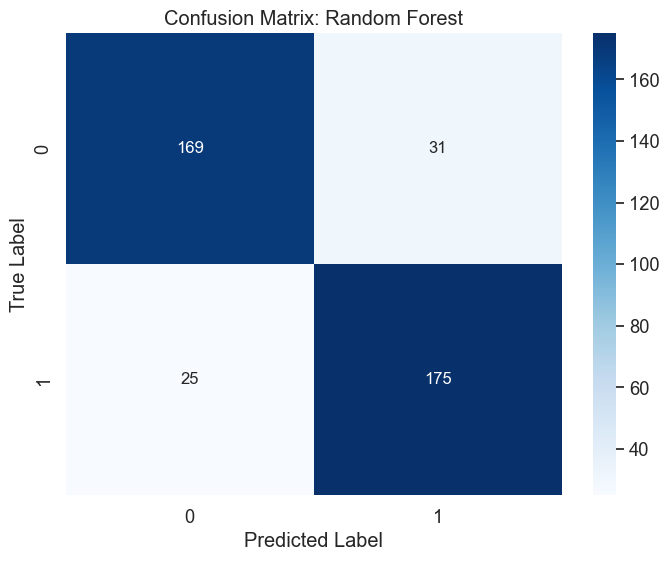

Evaluation Results for Random Forest:
Accuracy: 0.8600, Precision: 0.8603, F1 Score: 0.8600



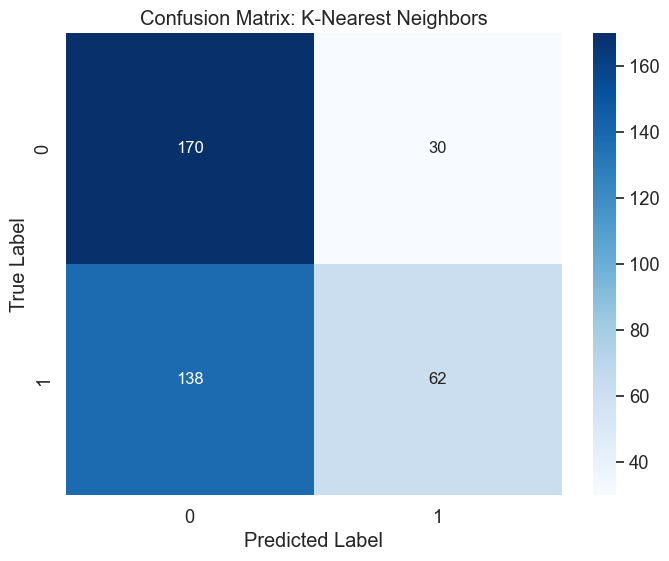

Evaluation Results for K-Nearest Neighbors:
Accuracy: 0.5800, Precision: 0.6129, F1 Score: 0.5470



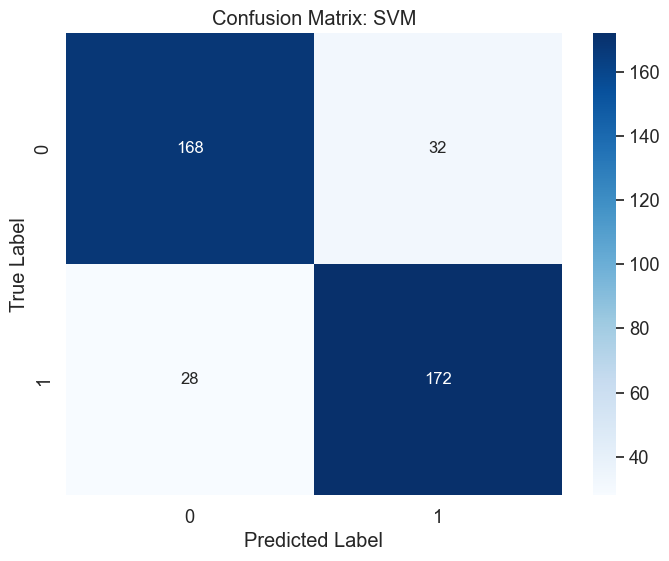

Evaluation Results for SVM:
Accuracy: 0.8500, Precision: 0.8501, F1 Score: 0.8500



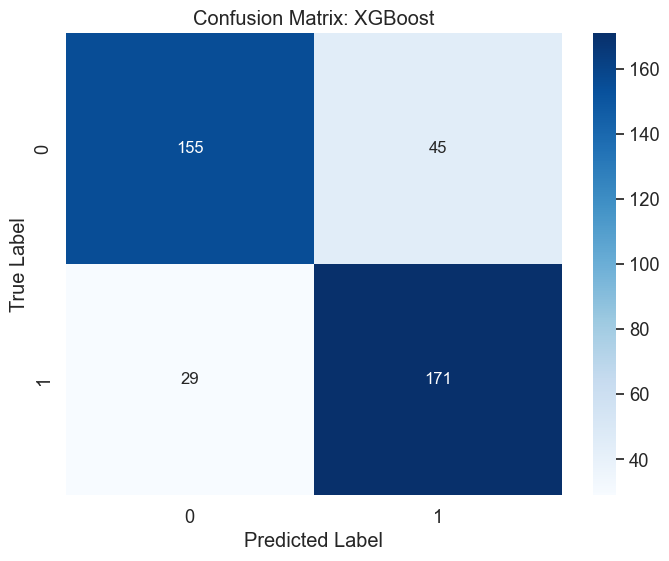

Evaluation Results for XGBoost:
Accuracy: 0.8150, Precision: 0.8170, F1 Score: 0.8147



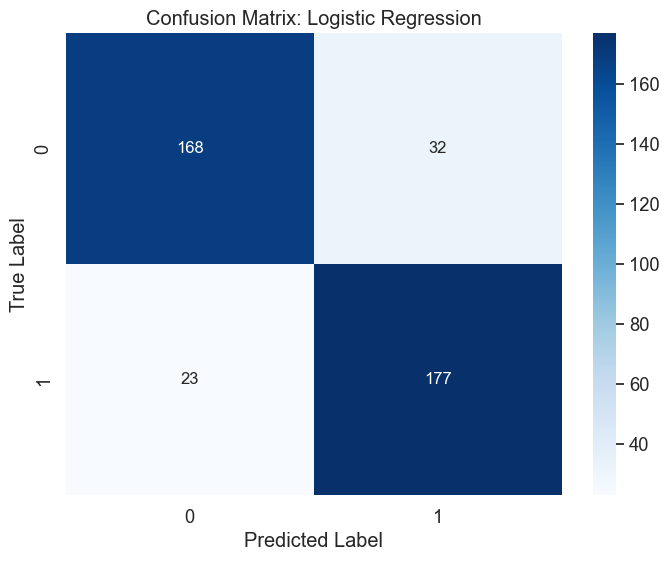

Evaluation Results for Logistic Regression:
Accuracy: 0.8625, Precision: 0.8632, F1 Score: 0.8624



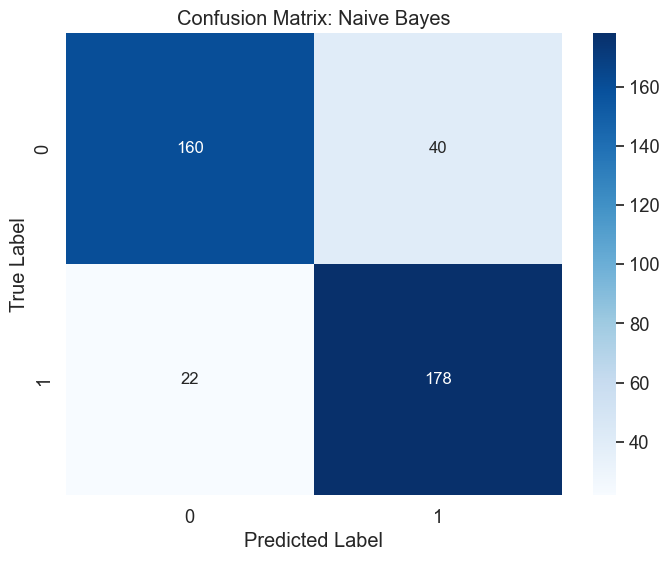

Evaluation Results for Naive Bayes:
Accuracy: 0.8450, Precision: 0.8478, F1 Score: 0.8447



In [55]:
# Iterate over each model and evaluate it on the test data

mistakes_dict = {}

for model_name, (model, encode_target) in classifiers.items():
    """
    For each model, evaluate it on the test data and display the confusion matrix.
    """
    conf_matrix, accuracy, precision, f1, mistakes = evaluate_model(model, data_train_processed, data_test_processed, y_train, y_test, encode_target)
    
    # Store the mistakes in a dictionary
    mistakes_dict[model_name] = mistakes
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 12}, cmap="Blues", fmt="g", xticklabels=True, yticklabels=True)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.savefig(f'./images/confusion_matrix_{model_name}.png')
    plt.show()

    # Print evaluation metrics
    print(f"Evaluation Results for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, F1 Score: {f1:.4f}\n")

## ANALYSIS OF THE BEST MODEL

In [56]:
# Find the best model

best_model_name = max(classifiers, key=lambda x: classifiers[x][0].score(data_test_processed, y_test))
best_model = classifiers[best_model_name][0]

print(f"The best model is: {best_model_name}\n")


The best model is: Logistic Regression



### REVIEWS THAT WERE MISCLASSIFIED BY THE BEST SUPERVISED MODEL

In [57]:
# Display the mistakes made by the best model

print(f"Mistakes made by the best model ({best_model_name}):\n")
for mistake in mistakes_dict[best_model_name]:
    index, actual, pred = mistake
    print(f"Actual: {actual}, Predicted: {pred}")
    print(f"Review: {X_test[index]}\n")

Mistakes made by the best model (Logistic Regression):

Actual: neg, Predicted: pos
Review: running time approximately 1hr 40mins reviewed by jack choo rating : the movie starts with a rather se7en - ish opening sequence , rather cool and sets the mood for things to come . the story propels the audience into a neo - reality ; somewhat very close to conscious reality but laced with weird tinges of blue and red . existenz is actually the name of a new virtual - reality game . supposedly , vr games are highly popular as is considered a legal - drug in this neo - reality . * * * * ( leigh ) is the ultimate game creator and introduces her ultimate game - experience in the form of existenz . players are required to have bio - ports embedded in their spine , which plugs to a game - pod in order to enjoy the immersive experience . during a secretive beta - testing - cum - teaser meeting for this new game , an assassination attempt on * * * life occurs and she runs off with fellow bodyguard * *

### FUNCTION TO PREDICT THE SENTIMENT OF A GIVEN REVIEW USING THE BEST SUPERVISED MODEL

In [68]:
def predict_sentiment_supervised(review, model, vectorizer):
    """
    Predicts the sentiment of a given review using the best model.

    Parameters:
    - review (str): The review to predict the sentiment for.
    - model: The best model for sentiment analysis.
    - vectorizer: The CountVectorizer object used to transform the data.

    Returns:
    - str: The predicted sentiment of the review.
    """
    # Preprocess the review
    review_processed = preprocessed_data(review)
    
    # Vectorize the preprocessed review
    review_vectorized = vectorizer.transform([review_processed])
    
    # Predict the sentiment
    prediction = model.predict(review_vectorized)
    
    return prediction[0]

# Test the function with a sample review
review = "This movie was terrible! The acting was bad and the special effects were horrible."

# Predict the sentiment of the review

sentiment = predict_sentiment_supervised(review, best_model, vectorizer)
print(f"Predicted sentiment: {sentiment}")


Predicted sentiment: neg


### FUNCTION TO PLOT THE ROC CURVE

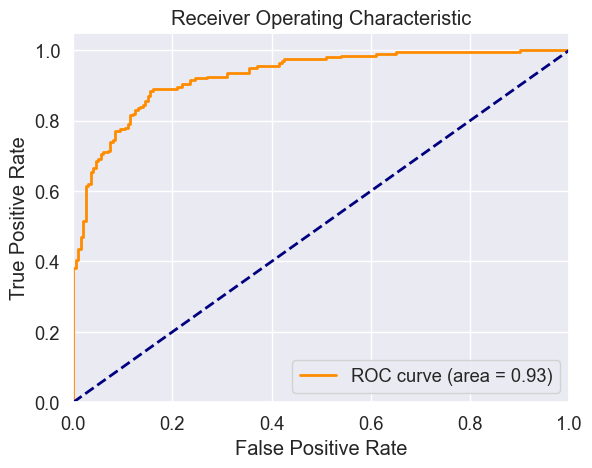

In [59]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, X, y):
    """
    Plots the ROC curve of the given model without using numpy for label conversion.
    Assumes 'pos' is the positive class and 'neg' is the negative class.
    
    Parameters:
    - model: The trained model that should have a `predict_proba` method.
    - X: Feature matrix for prediction.
    - y: Actual labels, expected to be 'pos' or 'neg'.
    """
    # Preprocess labels: Convert 'pos' -> 1, 'neg' -> 0
    y_numeric = [1 if label == 'pos' else 0 for label in y]
    
    # Predict probabilities
    y_scores = model.predict_proba(X)[:, 1]  # Assuming the positive class is at index 1
    
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_numeric, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # Plotting the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('./images/best_model_roc_curve.png')
    plt.show()

# Plot the ROC curve for the best model
plot_roc_curve(best_model, data_test_processed, y_test)

#  UNSUPERVISED SENTIMENT ANALYSIS WITH SENTIWORDNET AND LESK

### SCRIPT TO CLASSIFY A GIVEN REVIEW AND THE PARTS OF SPEECH (POS) CATEGORIES TO CONSIDER

In [99]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import sentiwordnet as swn
from nltk.wsd import lesk

def get_sentiwordnet_score(synset):
    """
    Get the SentiWordNet scores for a synset.
    """
    if not synset:
        return None  # Return None if no synset is provided
    
    # Get SentiWordNet scores for the synset
    swn_synset = swn.senti_synset(synset.name())
    return swn_synset.pos_score(), swn_synset.neg_score()


from nltk.corpus import wordnet as wn

def classify_review(review, use_pos=None):
    """
    Classify a review based on SentiWordNet scores, applying Lesk algorithm sentence-wise.
    
    Parameters:
    - review: the entire review text as a string.
    - use_pos: set of parts of speech categories to consider (e.g., {'n', 'v', 'a', 'r', 's'}).
    
    Returns:
    - String 'positive' or 'negative' as the overall sentiment of the review.
    """
    pos_scores = 0
    neg_scores = 0
    
    # Tokenize the review into sentences
    sentences = sent_tokenize(review)
    
    for sentence in sentences:
        words = word_tokenize(sentence)
        tagged_words = nltk.pos_tag(words)
        
        for word, pos in tagged_words:
            # Map POS tag to wordnet POS category
            wn_pos = None
            if pos.startswith('J'):
                wn_pos = wn.ADJ
            elif pos.startswith('N'):
                wn_pos = wn.NOUN
            elif pos.startswith('R'):
                wn_pos = wn.ADV
            elif pos.startswith('V'):
                wn_pos = wn.VERB

                        
            if use_pos is None or wn_pos in use_pos:
                # Apply the Lesk algorithm to get the best synset for the word
                synset = lesk(words, word, wn_pos)
                
                # If Lesk returns None for an adjective, attempt to find a satellite adjective synset
                if synset is None and wn_pos == wn.ADJ and 's' in use_pos:
                    synset = lesk(words, word, wn.ADJ_SAT)
                
                if synset:
                    # Get the SentiWordNet scores
                    sw_scores = get_sentiwordnet_score(synset)
                    if sw_scores:
                        pos_score, neg_score = sw_scores
                        pos_scores += pos_score
                        neg_scores += neg_score
    
    # Determine the overall sentiment
    return 'pos' if pos_scores >= neg_scores else 'neg'


### SCRIPT TO SEARCH THE BEST COMBINATIONS OF POS AND EVALUATE THE TEST RESULTS

 Progress done: 100.0%
Best POS combination val results: ('a', 's')
Accuracy: 0.6687, Precision: 0.6688, F1 Score: 0.6687

Best POS combination test results:
Accuracy: 0.6200, Precision: 0.6215, F1 Score: 0.6188



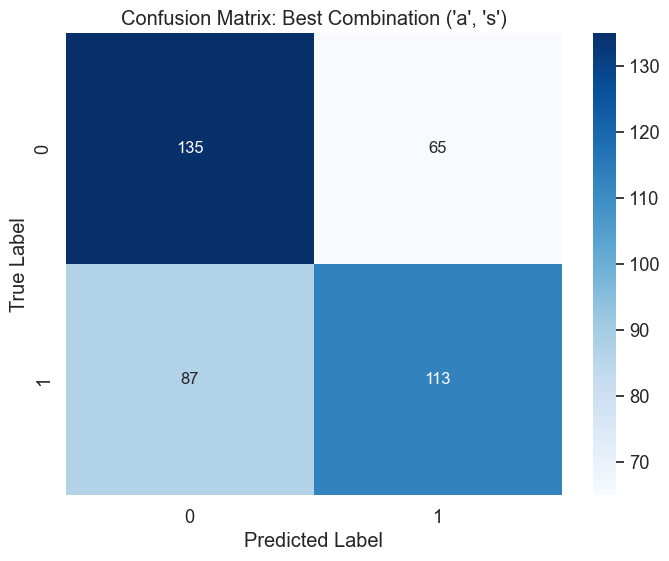

In [64]:
import itertools
from sklearn.model_selection import train_test_split

# Split the original training data into validation data (50% validation)
_, X_val, _, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=42)

# All possible non-empty combinations of POS
pos_combinations = []
for r in range(1, 5):
    pos_combinations.extend(list(itertools.combinations({'a', 'n', 'r', 'v', 's'}, r)))

best_combination = None
best_score = 0
evaluation_results = {}

# Iterate over all non-empty combinations of POS tags
combinations = len(pos_combinations)
progress = 0

for pos_combination in pos_combinations:
    progress += 1
    print('\r', f'Progress done: {round(progress*100/combinations,2)}%', end='')
    # Classify sentiments using the validation set
    sentiments = [classify_review(review, use_pos=set(pos_combination)) for review in X_val]
    accuracy = accuracy_score(y_val, sentiments)
    precision = precision_score(y_val, sentiments, average='macro', zero_division=0)
    f1 = f1_score(y_val, sentiments, average='macro', zero_division=0)

    # Store the results
    evaluation_results[pos_combination] = (accuracy, precision, f1)

    # Update the best combination based on validation F1 score
    if f1 > best_score:
        best_score = f1
        best_combination = pos_combination

# Print the best combination and its results
best_accuracy, best_precision, best_f1 = evaluation_results[best_combination]
print(f"\nBest POS combination val results: {best_combination}")
print(f"Accuracy: {best_accuracy:.4f}, Precision: {best_precision:.4f}, F1 Score: {best_f1:.4f}\n")

# Evaluate the selected combination on the test set
best_sentiments = [classify_review(review, use_pos=set(best_combination)) for review in X_test]
best_test_accuracy = accuracy_score(y_test, best_sentiments)
best_test_precision = precision_score(y_test, best_sentiments, average='macro', zero_division=0)
best_test_f1 = f1_score(y_test, best_sentiments, average='macro', zero_division=0)

print(f"Best POS combination test results:")
print(f"Accuracy: {best_test_accuracy:.4f}, Precision: {best_test_precision:.4f}, F1 Score: {best_test_f1:.4f}\n")
conf_matrix = confusion_matrix(y_test, best_sentiments)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 12}, cmap="Blues", fmt="g", xticklabels=True, yticklabels=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix: Best Combination {best_combination}')
plt.savefig('./images/best_confusion_matrix_sentiwordnet.png')
plt.show()

# List mistakes made by the best SentiWordNet-based classifier
mistakes_unsupervised = [(index, actual, pred) for index, (actual, pred) in enumerate(zip(y_test, best_sentiments)) if actual != pred]


### REVIEWS THAT WERE MISCLASSIFIED BY THE UNSUPERVISED MODEL

In [158]:
# Display the mistakes made by the unsupervised algorithm

print(f"Mistakes made by unsupervised algorithm:\n")
for mistake in mistakes_unsupervised:
    index, actual, pred = mistake
    print(f"Actual: {actual}, Predicted: {pred}")
    print(f"Review: {X_test[index]}\n")

Mistakes made by unsupervised algorithm:

Actual: neg, Predicted: pos
Review: dr dolittle ( 20th century fox ) running time : 1 hour 25 minutes starring eddie murphy directed by betty thomas riding high on the success of the nutty professor ( 1996 ) , murphy returns in this abysmal comedy . he plays doctor john dolittle , who as a child had the ability to understand animals . however , after being ' exorcised ' he loses this ability , and we fast forward to see dolittle in a crummy job surrounding by crummy people ( most notably dr mark weller , played by oliver platt . ) however , with a bonk on the head his ability to understand animals returns , and ' comedy ' is ready and waiting to happen . except comedy never does happen . doctor dolittle , even with the excellent premise , rarely manages to raise a laugh . poor old murphy looks bored stiff throughout the whole movie , and his performance suffers . the manic murphy we saw in the 80 ' s is gone , his more mature ( and more boring 

### FUNCTION TO PREDICT THE SENTIMENT OF A GIVEN REVIEW USING THE UNSUPERVISED MODEL

In [66]:

def predict_sentiment_unsupervised(review, use_pos=None):
    """
    Predicts the sentiment of a given review using unsupervised sentiment analysis.

    Parameters:
    - review (str): The review to predict the sentiment for.
    - use_pos (set): Set of parts of speech categories to consider (e.g., {'n', 'v', 'a', 'r', 's'}).

    Returns:
    - str: The predicted sentiment of the review.
    """
    return classify_review(review, use_pos)


# Predict the sentiment of a sample review using unsupervised sentiment analysis
review_text = "I watched this movie last night. The acting was great!"
sentiment = predict_sentiment_unsupervised(review_text, set(best_combination))
print(f"Predicted sentiment: {sentiment}")

Predicted sentiment: pos


# COMPARE THE BEST SUPERVISED MODEL AND UNSUPERVISED

In [77]:
def compare_results(review, model, vectorizer):
    """
    Compares the sentiment prediction results of the supervised and unsupervised models.

    Parameters:
    - review (str): The review to predict the sentiment for.
    - model: The best model for supervised sentiment analysis.
    - vectorizer: The CountVectorizer object used to transform the data.

    Returns:
    - Tuple of (supervised_sentiment, unsupervised_sentiment)
    """
    supervised_sentiment = predict_sentiment_supervised(review, model, vectorizer)
    unsupervised_sentiment = predict_sentiment_unsupervised(review, set(best_combination))
    
    return supervised_sentiment, unsupervised_sentiment


### COMPARE THE MODELS WITH A SET OF SHORT MOVIE REVIEWS

In [78]:
short_movie_reviews = [
    ("Absolutely loved this movie! The performances were outstanding and the storyline was captivating from start to finish. Highly recommend!", 'pos'),
    ("Terrible experience at this restaurant. The food was bland and arrived cold, and the service was unacceptably slow. Will not be returning.", 'neg'),
    ("This book can be a bit slow in places, but it beautifully captures the complexities of its characters. Worth a read!", 'pos'),
    ("Oh great, another sequel that nobody asked for. Just what we needed, more plot holes and forgettable characters.", 'neg'),
    ("I had high expectations based on the trailer, but the movie was both amazing and a bit disappointing. The visuals were stunning, though the plot was somewhat predictable.", 'neg'),
    ("Fantastic, another rainy day! Just perfect for my weekend plans.", 'pos'),
    ("The author presents a well-researched account of the history, though some chapters tend to drag due to excessive detail that contributes little to the overall narrative.", 'neg'),
    ("Watching this film took me back to my childhood. It's not just a movie; it's a piece of art that resonates with my personal experiences.", 'pos'),
    ("The camera quality is top-notch, capturing details perfectly. However, the battery life doesn’t live up to the promises made by the advertisement.", 'neg')
]



for review, actual_sentiment in short_movie_reviews:
    supervised_sentiment, unsupervised_sentiment = compare_results(review, best_model, vectorizer)
    
    print(f"Review: {review}")
    print(f"Actual Sentiment: {actual_sentiment}")
    print(f"Supervised Sentiment: {supervised_sentiment}")
    print(f"Unsupervised Sentiment: {unsupervised_sentiment}\n")

Review: Absolutely loved this movie! The performances were outstanding and the storyline was captivating from start to finish. Highly recommend!
Actual Sentiment: pos
Supervised Sentiment: neg
Unsupervised Sentiment: pos

Review: Terrible experience at this restaurant. The food was bland and arrived cold, and the service was unacceptably slow. Will not be returning.
Actual Sentiment: neg
Supervised Sentiment: neg
Unsupervised Sentiment: neg

Review: This book can be a bit slow in places, but it beautifully captures the complexities of its characters. Worth a read!
Actual Sentiment: pos
Supervised Sentiment: neg
Unsupervised Sentiment: pos

Review: Oh great, another sequel that nobody asked for. Just what we needed, more plot holes and forgettable characters.
Actual Sentiment: neg
Supervised Sentiment: neg
Unsupervised Sentiment: pos

Review: I had high expectations based on the trailer, but the movie was both amazing and a bit disappointing. The visuals were stunning, though the plot w

### COMPARE THE MODELS WITH A SET OF LONG MOVIE REVIEWS

In [80]:
long_movie_reviews = [
    ("The film presents an intricate tapestry of narrative threads woven together to create a stunning visual and emotional experience. From the opening scene to the closing credits, the director skillfully navigates through a complex plot filled with twists and turns that not only captivate but also leave a lasting impression. The cinematography is nothing short of breathtaking, capturing the essence of each location with such detail that it feels as though you are standing in the midst of the action. The color palette is carefully chosen to reflect the emotional undertones of each scene, adding depth and dimension to the storytelling. Performances by the ensemble cast are profound and nuanced, each actor bringing their character to life with a realism that is both touching and raw. The lead, in particular, delivers a powerhouse performance that could easily be considered a career best. The supporting characters are equally compelling, their own stories weaving in and out of the main narrative, enriching the overall texture of the film. The soundtrack complements the visual feast, its haunting melodies lingering long after the film has ended, evoking emotions that are hard to shake. The director’s use of symbolism is both clever and effective, with recurring motifs that enhance the thematic complexity of the work. Overall, this film is a masterclass in filmmaking, combining artistry with storytelling in a way that is rare and captivating. It is a film that challenges the viewer, not only to follow the intricate plot but to feel the profound emotions woven into the fabric of the story.", 'pos'),
    ("Unfortunately, this film, which had the potential to be a poignant exploration of relevant themes, turns out to be a tedious and pretentious affair. The director attempts to tackle too many complex issues at once, resulting in a muddled narrative that lacks focus and clarity. The film stretches on for what feels like an eternity, with endless scenes that add little to the overall story. The dialogue is often heavy-handed and unnatural, with characters delivering philosophical monologues that sound more like lectures than genuine conversations. This didactic approach detracts from the emotional impact of the film, leaving the viewer disengaged and disinterested. Moreover, the performances, while earnest, are hampered by a script that does not allow for much depth or development. Characters come across as stereotypes rather than real people, their motivations unclear and their actions often inexplicable. The cinematography, though visually striking at times, seems to prioritize style over substance, with an overuse of dramatic angles and lighting that feel contrived rather than artistic. The pacing is uneven, with the film struggling to maintain momentum and often losing its way amidst a sea of thematic explorations that never quite land. In its ambition to be profound, the film forgets the basics of storytelling, making it a frustrating and ultimately unsatisfying viewing experience.", 'neg'),
    ("This cinematic gem is a deep dive into the intricacies of human relationships set against a backdrop of breathtaking landscapes and historical contexts. The story unfolds slowly, drawing the viewer in with its rich character development and complex interpersonal dynamics. Each character is carefully crafted, with backstories that add layers of complexity to their interactions and conflicts. The narrative is skillfully structured, with flashbacks and foreshadowing used effectively to build suspense and enhance emotional engagement. The film’s exploration of themes such as love, betrayal, and redemption is thoughtful and profound, offering new insights into familiar tropes. The director’s attention to detail is evident in every scene, with each frame meticulously composed to contribute to the overall narrative arc. The actors deliver performances that are subtle yet powerful, capturing the nuances of their characters’ emotional journeys. The dialogue is sharp and insightful, with a script that balances poetic eloquence with raw honesty. The film’s climax is both surprising and satisfying, providing a resolution that feels both inevitable and earned. It is a movie that stays with you long after you leave the theater, its themes resonating and its images haunting. An unequivocal triumph in filmmaking, this movie not only entertains but also enlightens, making it a must-see for those who appreciate cinema that challenges as well as delights.", 'pos'),
    ("The film attempts to be an epic tale of intrigue and drama but fails spectacularly due to its overly complex plot and a plethora of underdeveloped subplots. The narrative tries to weave together different time periods and characters, but this ambition is its downfall, as the story becomes increasingly difficult to follow. The director seems to have prioritized quantity over quality, introducing countless characters and scenarios with little to no development or resolution. The result is a confusing jumble of scenes that feel disjointed and irrelevant to the main storyline. The dialogue is cumbersome and expository, with characters often serving as mere mouthpieces to explain the convoluted plot rather than driving the story forward with their actions. This lack of subtlety extends to the film’s attempts at symbolism, which are so blatant as to be almost laughable. The performances are uneven, with some actors struggling to make the most of their poorly written roles, while others overact in an attempt to bring some energy to the sluggish pace. The cinematography, while occasionally striking, cannot compensate for the narrative weaknesses, and the use of CGI often looks cheap and detracts from the authenticity of the setting. Ultimately, this film is a disappointing effort that wastes its potential and leaves the viewer feeling frustrated and unsatisfied.", 'neg'),
    ("The cinematic journey presented in this film transcends the traditional boundaries of storytelling, blending historical narratives with a rich tapestry of character studies. The director has woven an intricate web of themes encompassing love, betrayal, ambition, and redemption, which are explored through the lives of complex, multifaceted characters. Each scene is crafted with meticulous attention to detail, from the costumes that reflect the changing eras to the subtle use of lighting to convey the characters' inner turmoil. The narrative structure is both innovative and challenging, as it non-linearly traverses through different timelines, requiring the viewer to piece together the fragmented story. This approach, while demanding, enriches the viewing experience by allowing a depth of character development seldom seen in cinema. The protagonist, portrayed with a profound emotional depth by the lead actor, embarks on a personal journey that mirrors the broader historical upheavals depicted in the film. Supporting characters are not mere backdrops but have their own complex narratives that intersect with the main storyline in meaningful ways. The dialogue is both poetic and poignant, with each line delivered with a precision that resonates with the viewer long after the film has ended. Moreover, the cinematographic choices are bold and striking, utilizing a palette that reflects the emotional landscape of the story. The score, composed with a sensitivity to the film's nuanced themes, complements the visual spectacle with a haunting melody that underpins the tragic yet hopeful narrative. In sum, this film is a masterclass in filmmaking, demanding much from its viewers but offering even more in return. It is a testament to the power of cinema to transform and enlighten, making it a landmark film that will be discussed and revered for decades to come.", 'pos'),
    ("This film aims to be a grandiose epic, spanning multiple generations and continents, but falls dramatically short of its lofty ambitions. The director's attempt to cover such a broad scope results in a superficial treatment of potentially interesting themes, leaving much to be desired in terms of emotional depth and character development. The main issue lies in the overly ambitious plot, which introduces too many characters and subplots without sufficient development, causing the viewer to struggle with following the narrative thread. The dialogue, intended to be insightful and profound, often comes off as pretentious and disconnected from the characters' actual experiences. Additionally, the film's pacing is erratic, with some sections dragging on interminably while others rush through significant events with hardly any time for the viewer to engage emotionally. The performances, while adequate, are hampered by the weak script and lack of clear direction, leading to a mismatch between the actors' talents and the material they are given to work with. Visually, the film is a mixed bag, featuring some beautifully shot scenes that are unfortunately overshadowed by others that suffer from poor CGI and inconsistent cinematography. The soundtrack, rather than enhancing the emotional impact of the film, is often intrusive and mismatched with the on-screen action. Overall, the film is a disappointing execution of what could have been a powerful and engaging narrative. Its failure to effectively manage its narrative scope and develop its characters leaves it as a forgettable attempt in the genre of historical epics.", 'neg'),
    ("Set in a vividly realized dystopian future, this film not only captivates with its imaginative storytelling but also provokes deep thought about our current societal trajectory. The director expertly balances a fast-paced, action-packed plot with thoughtful social commentary, creating a film that is both entertaining and intellectually stimulating. The protagonist, a rebellious hacker, is portrayed with a compelling mixture of vulnerability and strength, making her an instant icon of resistance in a world dominated by oppressive technology. Her journey is one of both physical and emotional survival, as she navigates a series of challenges that test her resolve and moral compass. The supporting characters are equally well-developed, from the antagonist, a charismatic yet ruthless tech mogul, to the various allies the protagonist encounters, each adding depth and perspective to the story. The film’s visual style is striking, with a color palette that shifts from the stark grays of the city to the lush greens of the hidden rebel base, reflecting the film’s underlying theme of hope amidst despair. The action sequences are choreographed with precision and flair, making them thrilling without overshadowing the character-driven moments that form the heart of the film. Furthermore, the screenplay is a work of art, with dialogues that are sharp, witty, and laden with meaning, often veering into philosophical territories without becoming tedious. In conclusion, this film is a remarkable achievement in the realm of science fiction, offering a gripping narrative enriched with profound themes that resonate with contemporary issues. It stands as a beacon of innovative cinema, pushing the boundaries of genre to deliver a story that is as thought-provoking as it is visually spectacular.", 'pos')
]

for review, actual_sentiment in long_movie_reviews:
    supervised_sentiment, unsupervised_sentiment = compare_results(review, best_model, vectorizer)
    
    print(f"Review: {review}")
    print(f"Actual Sentiment: {actual_sentiment}")
    print(f"Supervised Sentiment: {supervised_sentiment}")
    print(f"Unsupervised Sentiment: {unsupervised_sentiment}\n")

Review: The film presents an intricate tapestry of narrative threads woven together to create a stunning visual and emotional experience. From the opening scene to the closing credits, the director skillfully navigates through a complex plot filled with twists and turns that not only captivate but also leave a lasting impression. The cinematography is nothing short of breathtaking, capturing the essence of each location with such detail that it feels as though you are standing in the midst of the action. The color palette is carefully chosen to reflect the emotional undertones of each scene, adding depth and dimension to the storytelling. Performances by the ensemble cast are profound and nuanced, each actor bringing their character to life with a realism that is both touching and raw. The lead, in particular, delivers a powerhouse performance that could easily be considered a career best. The supporting characters are equally compelling, their own stories weaving in and out of the mai

On one hand we can clearly see that the supervised model although given a short review it always predicts 'neg' when we give a larger input its prediction ability augments a lot. On the other hand the unsupervised algorithm is more stable and not influencied by the length of the review but its results are much worse overall.

# NEGATIVE DETECTION AND INVERSE OF SENTIMENT

In [146]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import sentiwordnet as swn
from nltk.wsd import lesk
from nltk.corpus import wordnet as wn

def get_wordnet_pos(treebank_tag):
    """Convert treebank tags to wordnet tags."""
    if treebank_tag.startswith('J'):
        return wn.ADJ
    elif treebank_tag.startswith('V'):
        return wn.VERB
    elif treebank_tag.startswith('N'):
        return wn.NOUN
    elif treebank_tag.startswith('R'):
        return wn.ADV
    else:
        return None

def get_sentiwordnet_score(synset):
    """Get the SentiWordNet scores for a synset."""
    if not synset:
        return None  # Return None if no synset is provided
    
    swn_synset = swn.senti_synset(synset.name())
    return swn_synset.pos_score(), swn_synset.neg_score()

def classify_review_with_negative_inverse(review, use_pos=None):
    """Classify a review based on SentiWordNet scores, applying Lesk algorithm sentence-wise and considering immediate negations."""
    pos_scores = 0
    neg_scores = 0
    negation_tokens = {'no', 'not', 'never', 'nothing', 'nobody', 'none', 'neither', 'nor', 'nowhere', 'hardly', 'scarcely', 'barely', 'don’t', "doesn't", "isn't", "wasn't", "shouldn't", "wouldn't", "couldn't", "won't", "can't", "haven't", "hasn't", "hadn't", "n't"}
    last_was_negation = False  # Track if the last word was a negation
    
    # Tokenize the review into sentences
    sentences = sent_tokenize(review)
    
    for sentence in sentences:
        words = word_tokenize(sentence)
        tagged_words = nltk.pos_tag(words)
        
        for i, (word, pos) in enumerate(tagged_words):
            # Check if the current word is a negation
            if word.lower() in negation_tokens:
                last_was_negation = True
            else:
                wn_pos = get_wordnet_pos(pos)
                
                if use_pos is None or wn_pos in use_pos:
                    synset = lesk(words, word, wn_pos)
                    # If Lesk returns None for an adjective, attempt to find a satellite adjective synset
                    if synset is None and wn_pos == wn.ADJ and (use_pos is None or 's' in use_pos):
                        synset = lesk(words, word, wn.ADJ_SAT)
                    if synset:
                        pos_score, neg_score = get_sentiwordnet_score(synset)
                        if pos_score or neg_score:
                            # Invert the scores if the last word was a negation
                            if last_was_negation:
                                pos_score, neg_score = neg_score, pos_score
                            
                            pos_scores += pos_score
                            neg_scores += neg_score
                            
                # Reset the negation flag after processing the next word
                last_was_negation = False
    
    # Determine the overall sentiment
    return 'pos' if pos_scores >= neg_scores else 'neg'


### SIMPLE EXAMPLE COMPARED WITH THE PREVIOUS UNSUPERVISED ALGORITHM

In [151]:
classification_with_negative_inverse = classify_review_with_negative_inverse("I don't like this movie. It's not good.", {'a', 'n', 'v', 'r', 's'})
classification_without_negative_inverse = classify_review("I don't like this movie. It's not good.", {'a', 'n', 'v', 'r', 's'})

print(f"Classification with negative inverse: {classification_with_negative_inverse}")
print(f"Classification without negative inverse: {classification_without_negative_inverse}")

Classification with negative inverse: neg
Classification without negative inverse: pos


In [156]:
predictions_negative_inverse =  [classify_review_with_negative_inverse(review, {'a', 's', 'r'}) for review in X_test]
accuracy_negative_inverse = accuracy_score(y_test, predictions_negative_inverse)
precision_negative_inverse = precision_score(y_test, predictions_negative_inverse, average='macro', zero_division=0)
f1_negative_inverse = f1_score(y_test, predictions_negative_inverse, average='macro', zero_division=0)

print(f"Negative Inverse test results:")
print(f"Accuracy: {accuracy_negative_inverse:.4f}, Precision: {precision_negative_inverse:.4f}, F1 Score: {f1_negative_inverse:.4f}\n")
conf_matrix_negative_inverse = confusion_matrix(y_test, predictions_negative_inverse)

Negative Inverse test results:
Accuracy: 0.6575, Precision: 0.6631, F1 Score: 0.6545

